In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def generate_synthetic_ecg(length=7000, num_samples=100):
    """Генерация синтетических ЭКГ-сигналов с шумом."""
    t = np.linspace(0, 10, length)
    ecg_samples = []
    for _ in range(num_samples):
        main_peak = np.sin(2 * np.pi * 5 * t) * np.exp(-0.5 * (t - 5)**2 / 0.2)
        noise = 0.1 * np.random.randn(length)
        ecg_samples.append(main_peak + noise)
    return np.stack(ecg_samples)

# Загрузка или генерация данных
ecg_data = generate_synthetic_ecg(length=7000, num_samples=1000)  # (1000, 7000)

In [4]:
def split_into_windows(data, window_size=250, stride=125):
    windows = []
    for sample in data:
        for i in range(0, len(sample) - window_size + 1, stride):
            windows.append(sample[i:i+window_size])
    return np.stack(windows)

window_size = 250
X = split_into_windows(ecg_data, window_size=window_size)  # (N, 250)
X = X[:, :, np.newaxis]  # (N, 250, 1)

# Нормализация
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, 1)).reshape(-1, window_size, 1)

# Разделение на train/test
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Конвертация в тензоры
train_data = torch.FloatTensor(X_train).to(device)
test_data = torch.FloatTensor(X_test).to(device)

train_loader = DataLoader(TensorDataset(train_data, train_data), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data, test_data), batch_size=32)

In [17]:
ecg_data.shape

(1000, 7000)

In [15]:
X.shape

(55000, 250, 1)

In [7]:
class AttentionLayer(nn.Module):
    """Механизм внимания для временных рядов."""
    def __init__(self, hidden_dim):
        super().__init__()
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        # x: (batch, seq_len, hidden_dim)
        Q = self.query(x)
        K = self.key(x)
        scores = torch.matmul(Q, K.transpose(1, 2)) / torch.sqrt(torch.tensor(x.shape[-1]))
        weights = torch.softmax(scores, dim=-1)
        return torch.matmul(weights, x)

class ECGEncoder(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(64, hidden_dim, batch_first=True)
        self.attention = AttentionLayer(hidden_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, 1, seq_len) -> (batch, channels, seq_len)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.permute(0, 2, 1)  # (batch, seq_len, channels)
        x, _ = self.lstm(x)
        x = self.attention(x)
        return x

class ECGDecoder(nn.Module):
    def __init__(self, hidden_dim=64, output_dim=1):
        super().__init__()
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.upconv1 = nn.ConvTranspose1d(
            hidden_dim, 32, 
            kernel_size=3, 
            stride=2,
            output_padding=1  # Добавляем, чтобы размерность совпала
        )
        self.upconv2 = nn.ConvTranspose1d(
            32, output_dim, 
            kernel_size=5, 
            stride=2,
            padding=2,        # Корректируем padding
            output_padding=1  # Добавляем
        )
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x.permute(0, 2, 1)  # (batch, channels, seq_len)
        x = torch.relu(self.upconv1(x))
        x = torch.sigmoid(self.upconv2(x))
        return x.permute(0, 2, 1)[:, :250, :]  # Обрезаем до 250 точек

class ECGAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ECGEncoder()
        self.decoder = ECGDecoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
model = ECGAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

def train_model(epochs=50):
    best_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            x, _ = batch
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, x)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Валидация
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                x, _ = batch
                output = model(x)
                val_loss += criterion(output, x).item()
        
        avg_val_loss = val_loss / len(test_loader)
        scheduler.step(avg_val_loss)
        
        # Ранняя остановка
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "../weights/best_model.pth")
        
        print(f"Epoch {epoch+1}: Train Loss = {train_loss/len(train_loader):.4f}, Val Loss = {avg_val_loss:.4f}")

train_model(epochs=1)

Epoch 1: 100%|██████████| 1375/1375 [00:40<00:00, 34.30it/s]


Epoch 1: Train Loss = 0.8089, Val Loss = 0.7259


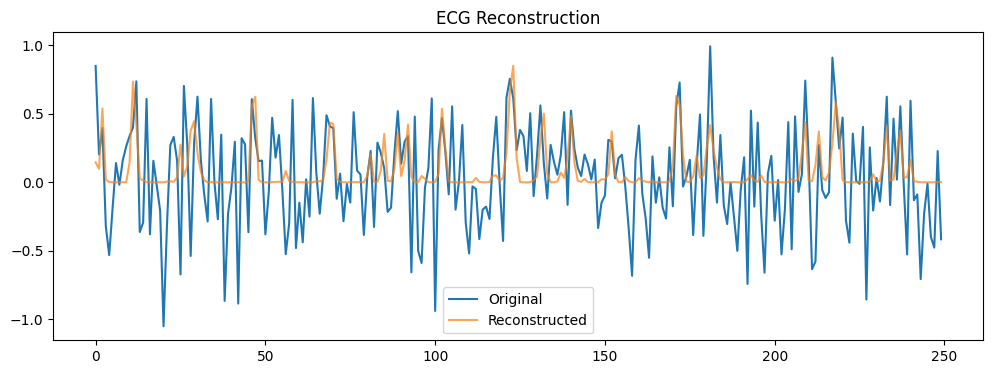

In [10]:
def plot_reconstruction(model, sample_idx=0):
    model.eval()
    with torch.no_grad():
        sample = test_data[sample_idx].unsqueeze(0)
        reconstructed = model(sample).cpu().numpy()
    
    plt.figure(figsize=(12, 4))
    plt.plot(test_data[sample_idx].cpu().numpy(), label="Original")
    plt.plot(reconstructed[0], label="Reconstructed", alpha=0.7)
    plt.legend()
    plt.title("ECG Reconstruction")
    plt.show()

plot_reconstruction(model)

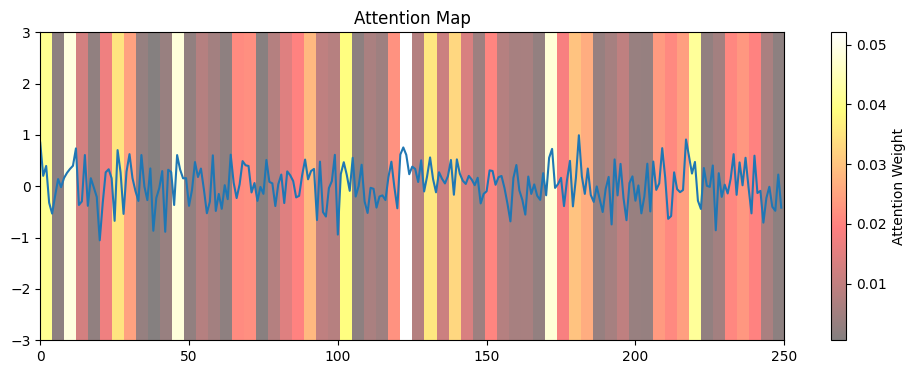

In [13]:
def plot_attention(model, sample_idx=0):
    model.eval()
    sample = test_data[sample_idx].unsqueeze(0)
    encoded = model.encoder(sample)
    
    # Получение весов внимания
    Q = model.encoder.attention.query(encoded)
    K = model.encoder.attention.key(encoded)
    scores = torch.matmul(Q, K.transpose(1, 2)) / torch.sqrt(torch.tensor(encoded.shape[-1]))
    weights = torch.softmax(scores, dim=-1).mean(dim=1).squeeze().detach().cpu().numpy()  # Добавлен .detach()
    
    plt.figure(figsize=(12, 4))
    plt.plot(test_data[sample_idx].cpu().numpy(), label="ECG")
    plt.imshow(weights[np.newaxis, :], cmap="hot", aspect="auto", alpha=0.5, extent=(0, window_size, -3, 3))
    plt.colorbar(label="Attention Weight")
    plt.title("Attention Map")
    plt.show()

plot_attention(model)